In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 30

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
META_FILE = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/model.ckpt-1664.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/model.ckpt-1664


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 30

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [14]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [15]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [16]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, HybridDPLL)
    if light == False:
        compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

 40%|████      | 4/10 [00:00<00:00, 29.24it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 22.08it/s]


#Sats: 10; avg step: 1053.10; stdev step: 773.49; avg error: 6.30; stdev error: 1.19


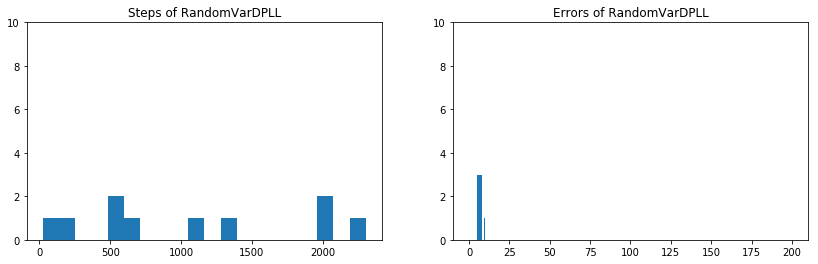

100%|██████████| 10/10 [00:00<00:00, 33.18it/s]


#Sats: 10; avg step: 541.90; stdev step: 368.27; avg error: 4.10; stdev error: 1.30


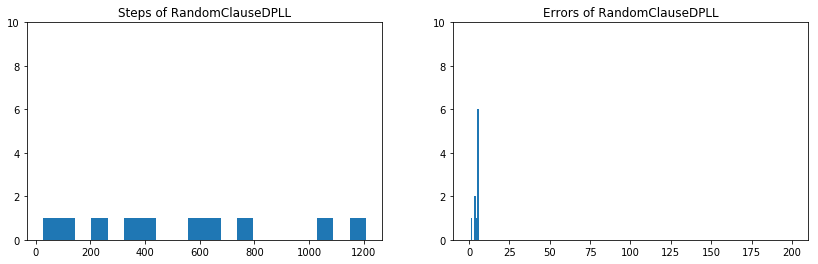

100%|██████████| 10/10 [00:22<00:00,  2.69s/it]


#Sats: 10; avg step: 276.50; stdev step: 354.77; avg error: 1.10; stdev error: 1.37


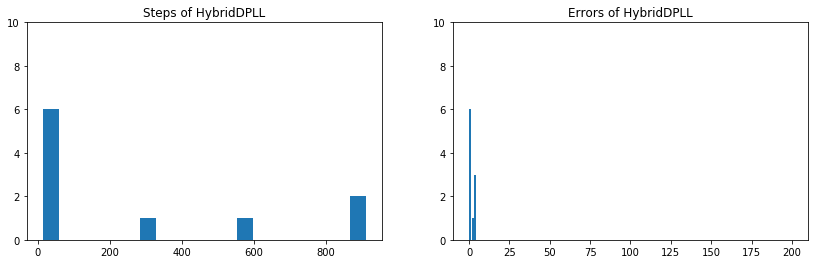

100%|██████████| 10/10 [01:15<00:00, 11.92s/it]


#Sats: 10; avg step: 364.70; stdev step: 472.99; avg error: 0.50; stdev error: 0.67


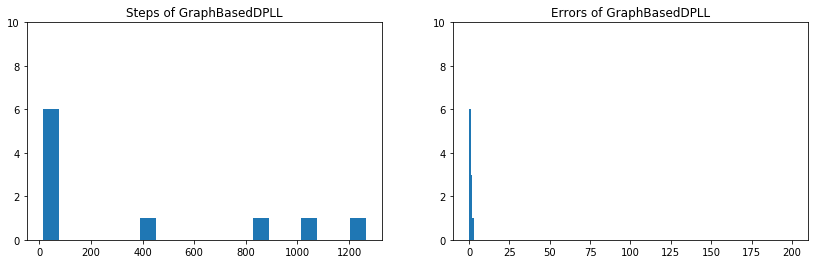

100%|██████████| 10/10 [00:00<00:00, 66.80it/s]


#Sats: 10; avg step: 224.60; stdev step: 171.61; avg error: 1.90; stdev error: 1.14


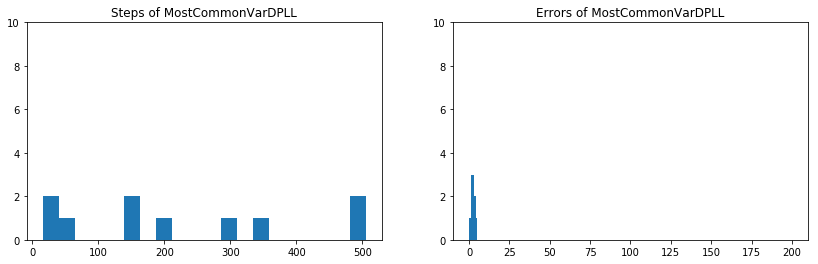

In [17]:
print_all(10, 200, 15)

100%|██████████| 10/10 [00:00<00:00, 333.84it/s]

We have generated 10 formulas
#Sats: 10; avg step: 71.90; stdev step: 46.70; avg error: 4.10; stdev error: 1.70


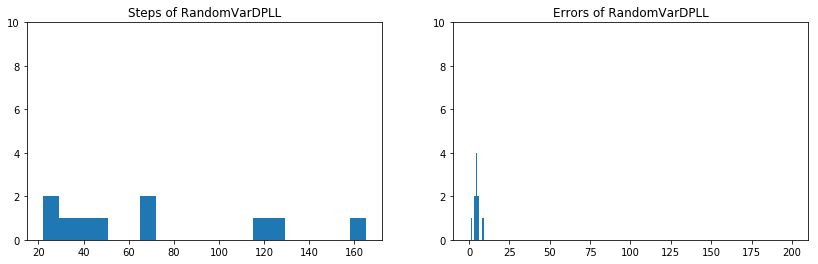

100%|██████████| 10/10 [00:00<00:00, 436.64it/s]


#Sats: 10; avg step: 68.60; stdev step: 19.52; avg error: 2.80; stdev error: 0.75


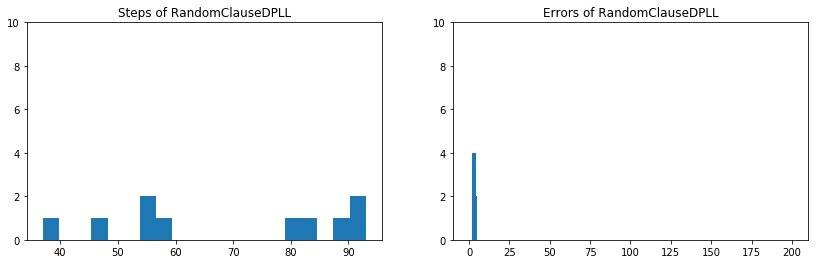

100%|██████████| 10/10 [00:04<00:00,  1.79it/s]


#Sats: 10; avg step: 19.80; stdev step: 23.55; avg error: 0.20; stdev error: 0.40


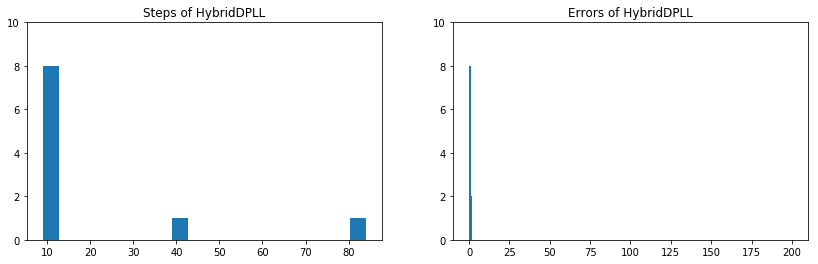

100%|██████████| 10/10 [00:04<00:00,  1.71it/s]


#Sats: 10; avg step: 19.80; stdev step: 23.55; avg error: 0.20; stdev error: 0.40


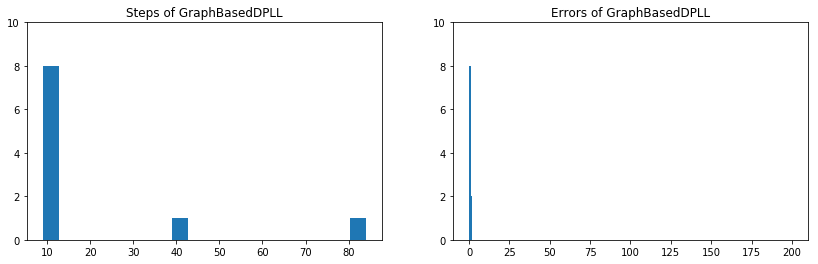

100%|██████████| 10/10 [00:00<00:00, 598.40it/s]


#Sats: 10; avg step: 22.80; stdev step: 11.42; avg error: 1.20; stdev error: 0.40


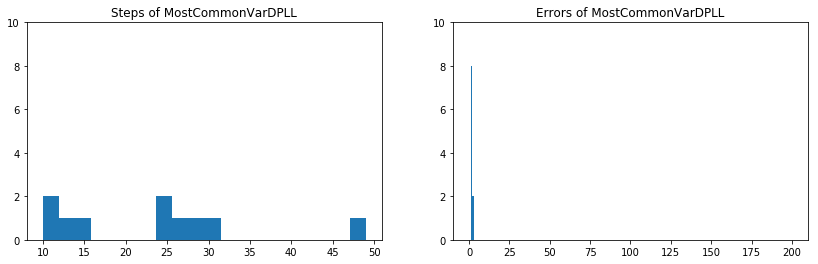

In [18]:
print_all(10, 200, 8)

100%|██████████| 10/10 [00:00<00:00, 125.42it/s]

We have generated 10 formulas
#Sats: 10; avg step: 142.70; stdev step: 73.11; avg error: 4.70; stdev error: 1.00


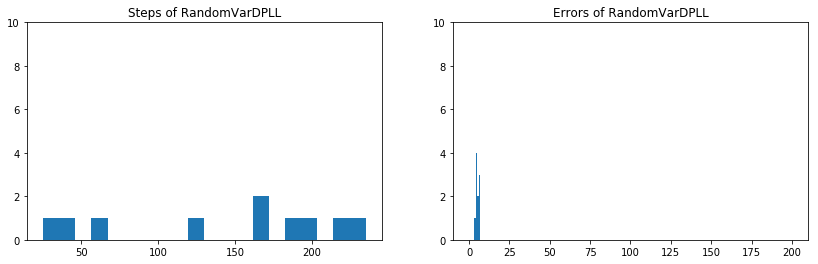

100%|██████████| 10/10 [00:00<00:00, 115.48it/s]


#Sats: 10; avg step: 127.20; stdev step: 59.41; avg error: 2.70; stdev error: 0.90


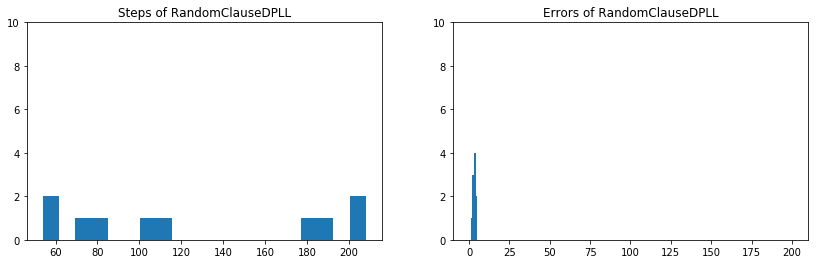

100%|██████████| 10/10 [00:06<00:00,  1.84it/s]


#Sats: 10; avg step: 26.50; stdev step: 41.00; avg error: 0.20; stdev error: 0.40


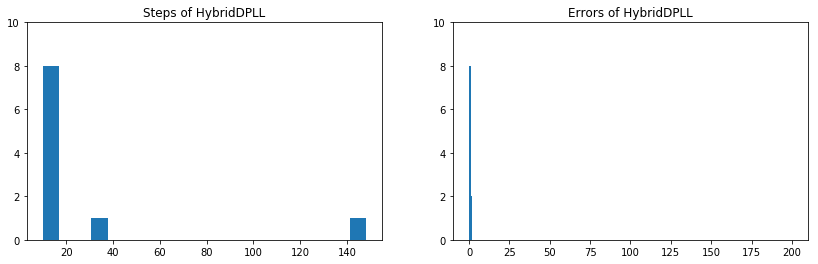

100%|██████████| 10/10 [00:07<00:00,  1.57it/s]


#Sats: 10; avg step: 26.50; stdev step: 41.00; avg error: 0.20; stdev error: 0.40


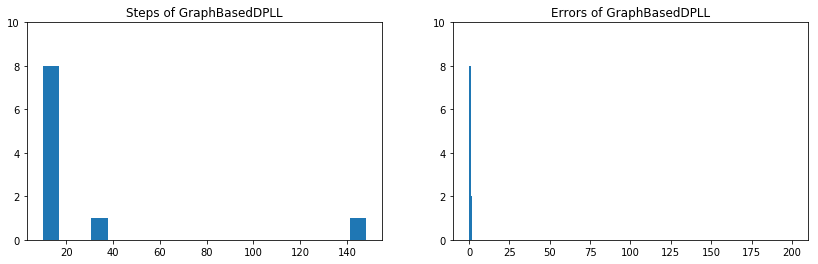

100%|██████████| 10/10 [00:00<00:00, 245.11it/s]


#Sats: 10; avg step: 45.40; stdev step: 38.80; avg error: 1.40; stdev error: 0.80


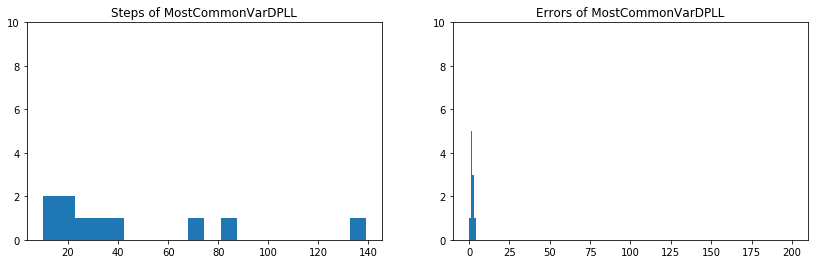

In [19]:
print_all(10, 200, 10)

100%|██████████| 10/10 [00:00<00:00, 61.46it/s]

We have generated 10 formulas
#Sats: 10; avg step: 385.30; stdev step: 178.97; avg error: 6.30; stdev error: 1.68


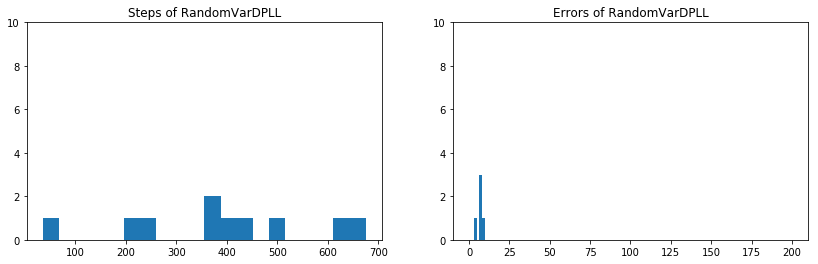

100%|██████████| 10/10 [00:00<00:00, 93.55it/s]


#Sats: 10; avg step: 204.30; stdev step: 153.59; avg error: 3.00; stdev error: 1.10


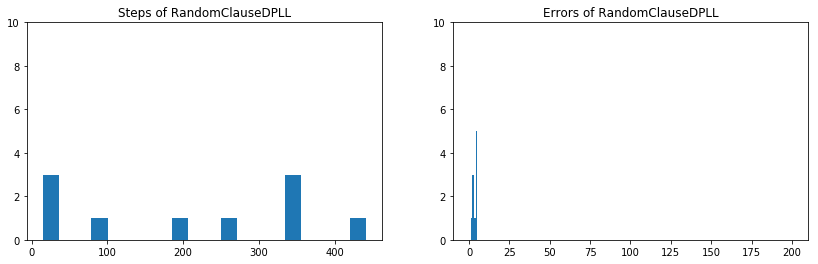

100%|██████████| 10/10 [00:08<00:00,  1.55it/s]


#Sats: 10; avg step: 34.20; stdev step: 42.65; avg error: 0.20; stdev error: 0.40


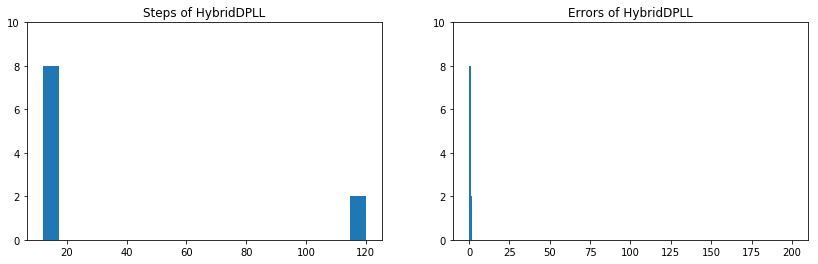

100%|██████████| 10/10 [00:08<00:00,  1.44it/s]


#Sats: 10; avg step: 34.20; stdev step: 42.65; avg error: 0.20; stdev error: 0.40


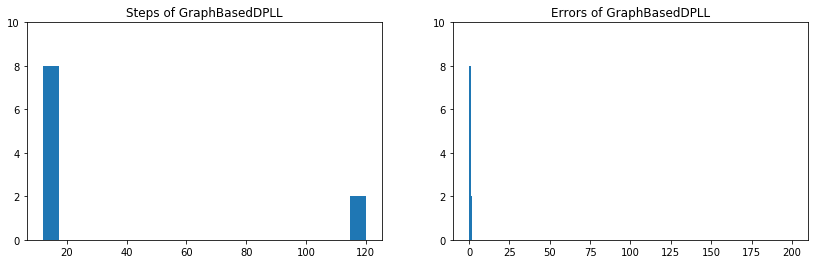

100%|██████████| 10/10 [00:00<00:00, 205.67it/s]


#Sats: 10; avg step: 59.80; stdev step: 49.77; avg error: 1.40; stdev error: 1.11


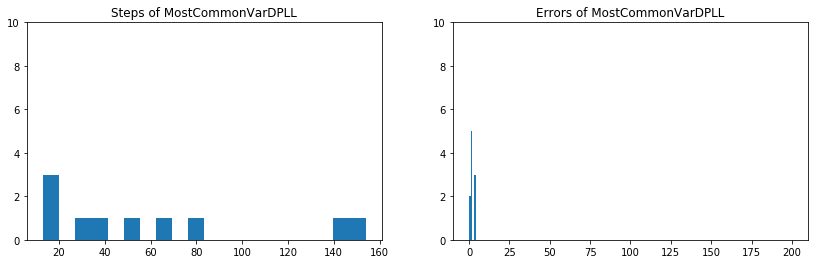

In [20]:
print_all(10, 200, 12)

100%|██████████| 10/10 [00:00<00:00, 54.90it/s]

We have generated 10 formulas
#Sats: 10; avg step: 427.60; stdev step: 310.09; avg error: 6.60; stdev error: 1.56


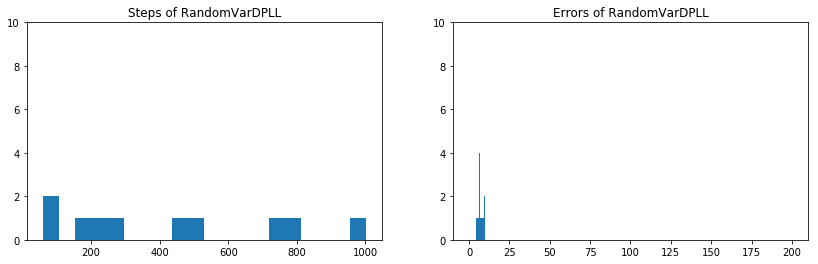

100%|██████████| 10/10 [00:00<00:00, 54.54it/s]


#Sats: 10; avg step: 376.60; stdev step: 192.03; avg error: 3.70; stdev error: 0.64


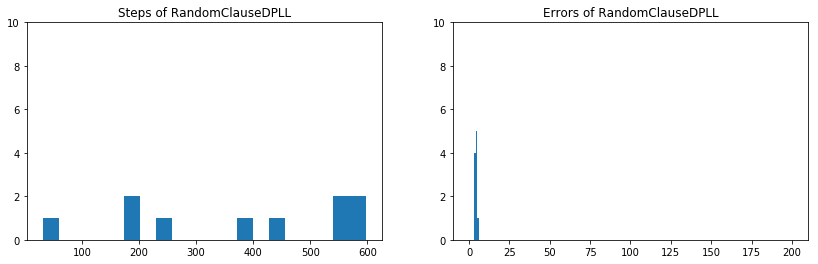

100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


#Sats: 10; avg step: 14.50; stdev step: 0.67; avg error: 0.00; stdev error: 0.00


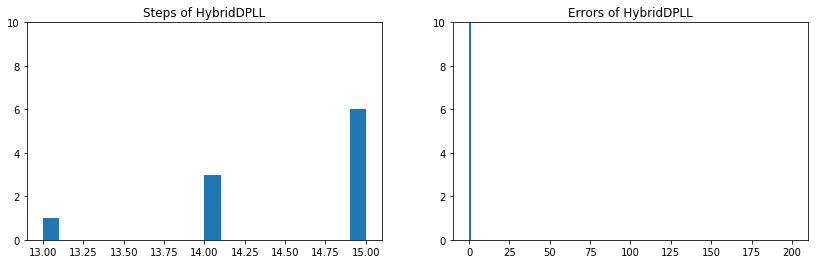

100%|██████████| 10/10 [00:07<00:00,  1.21it/s]


#Sats: 10; avg step: 14.50; stdev step: 0.67; avg error: 0.00; stdev error: 0.00


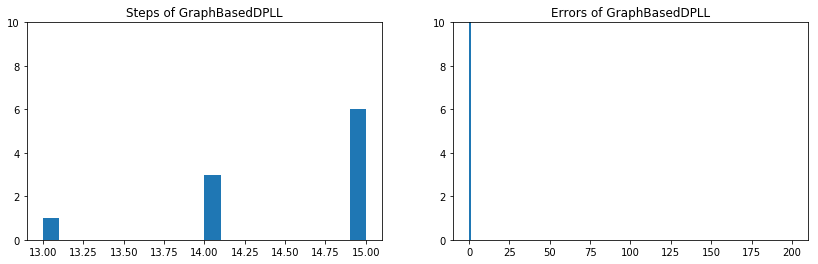

100%|██████████| 10/10 [00:00<00:00, 115.26it/s]


#Sats: 10; avg step: 81.90; stdev step: 77.46; avg error: 2.00; stdev error: 1.00


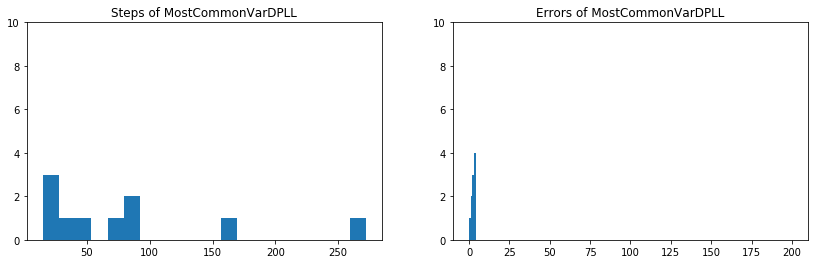

In [21]:
print_all(10, 200, 14)

 30%|███       | 3/10 [00:00<00:00, 10.42it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 17.58it/s]


#Sats: 10; avg step: 1121.30; stdev step: 674.91; avg error: 7.90; stdev error: 2.21


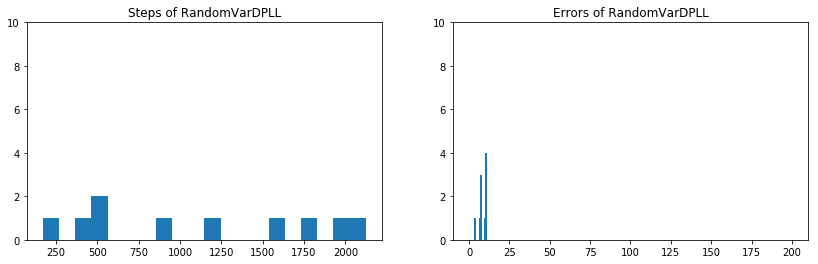

100%|██████████| 10/10 [00:00<00:00, 20.47it/s]


#Sats: 10; avg step: 846.40; stdev step: 589.48; avg error: 4.80; stdev error: 1.33


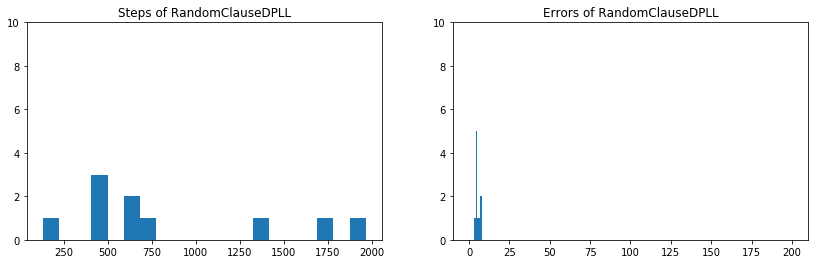

100%|██████████| 10/10 [00:18<00:00,  2.31s/it]


#Sats: 10; avg step: 160.90; stdev step: 244.95; avg error: 0.80; stdev error: 1.25


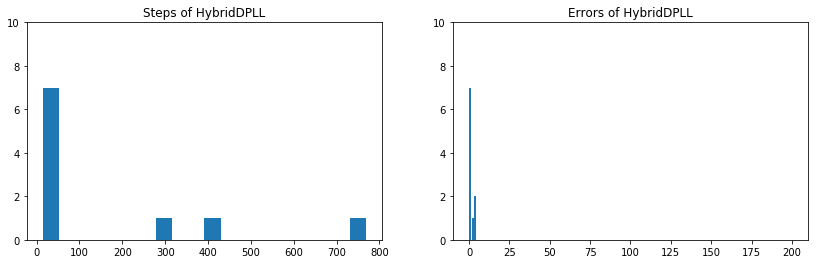

100%|██████████| 10/10 [00:46<00:00,  5.99s/it]


#Sats: 10; avg step: 184.00; stdev step: 291.56; avg error: 0.30; stdev error: 0.46


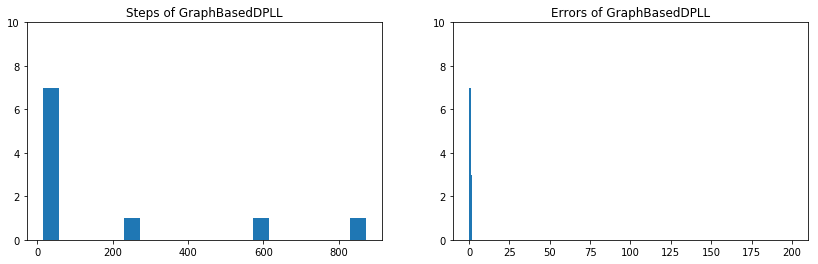

100%|██████████| 10/10 [00:00<00:00, 34.54it/s]


#Sats: 10; avg step: 334.20; stdev step: 263.28; avg error: 2.40; stdev error: 1.36


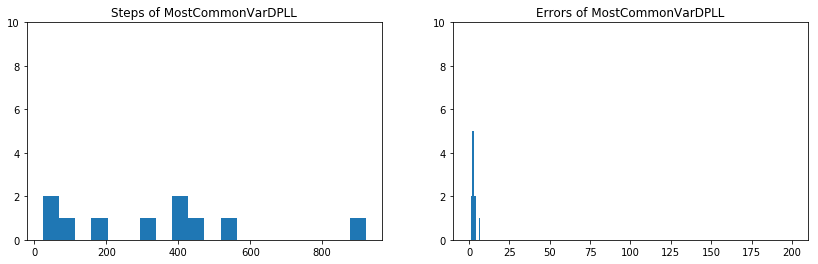

In [22]:
print_all(10, 200, 16)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


#Sats: 10; avg step: 3607.00; stdev step: 1391.21; avg error: 9.00; stdev error: 1.79


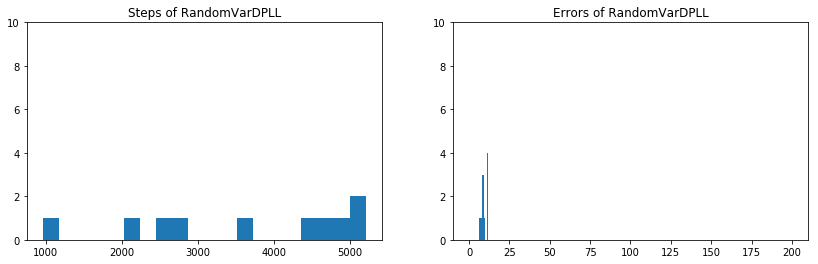

100%|██████████| 10/10 [00:00<00:00, 11.13it/s]


#Sats: 10; avg step: 1579.00; stdev step: 895.58; avg error: 5.30; stdev error: 1.42


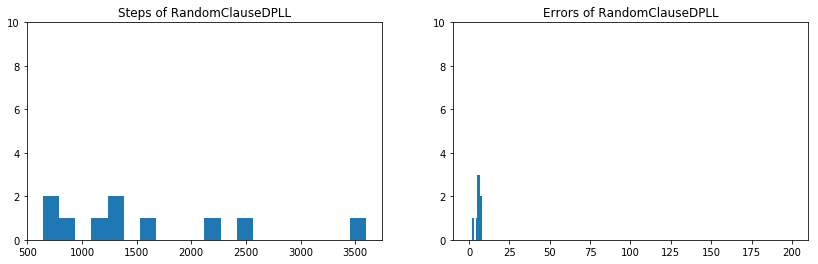

100%|██████████| 10/10 [00:16<00:00,  1.32s/it]


#Sats: 10; avg step: 188.90; stdev step: 367.75; avg error: 0.60; stdev error: 1.28


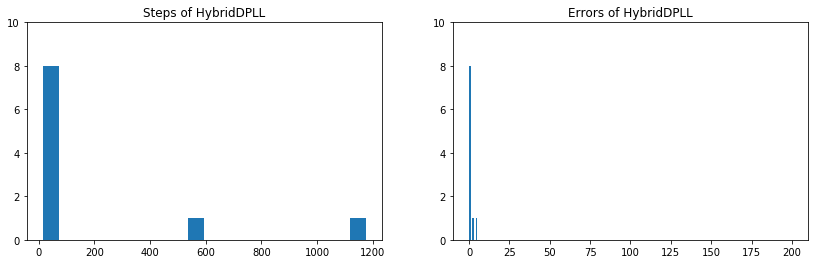

100%|██████████| 10/10 [01:13<00:00,  3.36s/it]


#Sats: 10; avg step: 304.70; stdev step: 618.83; avg error: 0.40; stdev error: 0.80


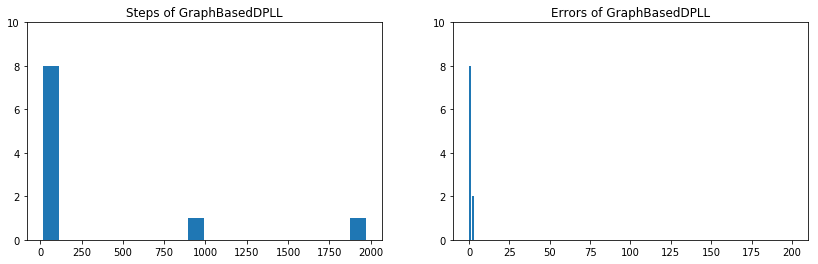

100%|██████████| 10/10 [00:00<00:00, 37.46it/s]


#Sats: 10; avg step: 414.30; stdev step: 444.98; avg error: 2.50; stdev error: 1.36


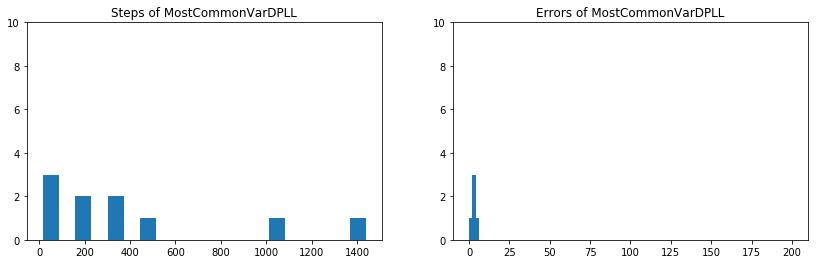

In [23]:
print_all(10, 200, 18)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


#Sats: 10; avg step: 4931.20; stdev step: 2659.53; avg error: 10.40; stdev error: 1.50


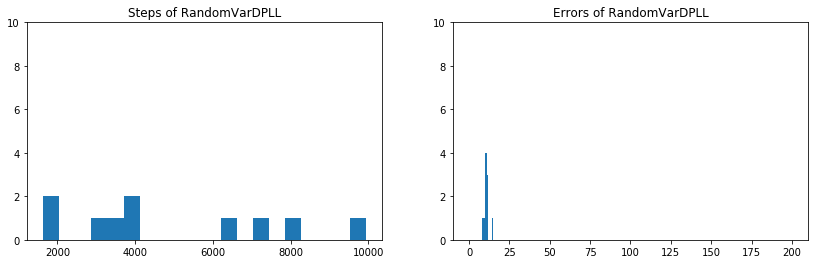

100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


#Sats: 10; avg step: 3767.70; stdev step: 1256.23; avg error: 5.80; stdev error: 1.47


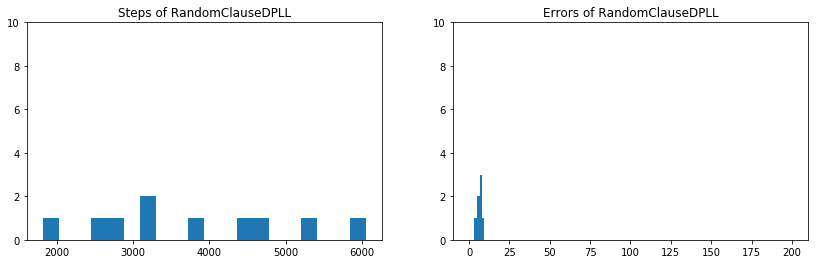

100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


#Sats: 10; avg step: 594.80; stdev step: 777.73; avg error: 1.20; stdev error: 1.66


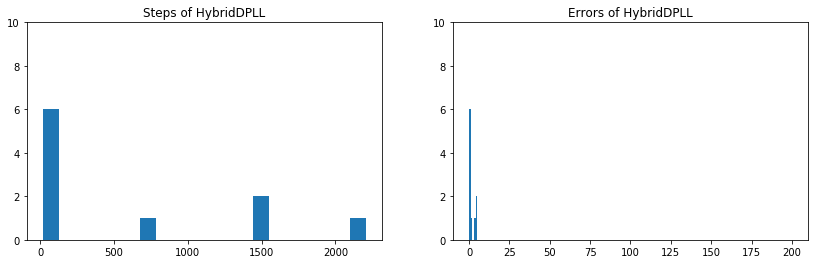

100%|██████████| 10/10 [03:10<00:00, 20.70s/it]


#Sats: 10; avg step: 869.60; stdev step: 1192.24; avg error: 0.50; stdev error: 0.67


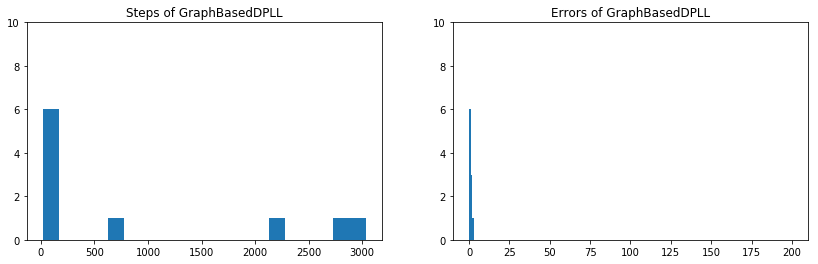

100%|██████████| 10/10 [00:00<00:00, 13.13it/s]


#Sats: 10; avg step: 761.60; stdev step: 526.89; avg error: 3.00; stdev error: 1.34


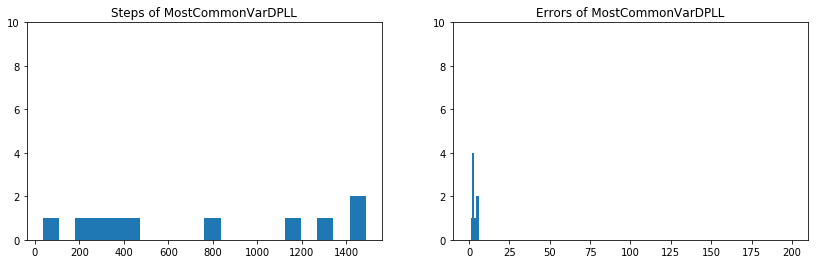

In [24]:
print_all(10, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:20<00:00,  2.18s/it]


#Sats: 10; avg step: 28452.40; stdev step: 13995.03; avg error: 12.50; stdev error: 2.77


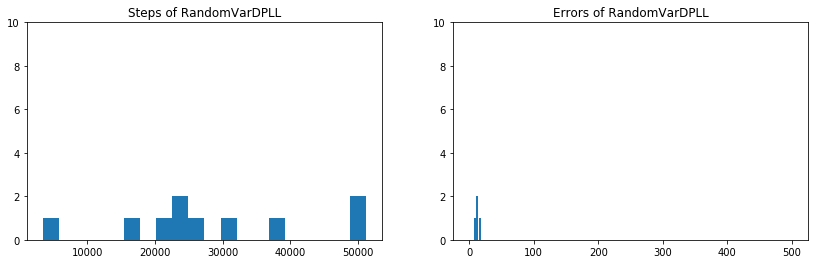

100%|██████████| 10/10 [00:09<00:00,  1.02s/it]


#Sats: 10; avg step: 12053.40; stdev step: 9659.55; avg error: 7.50; stdev error: 2.29


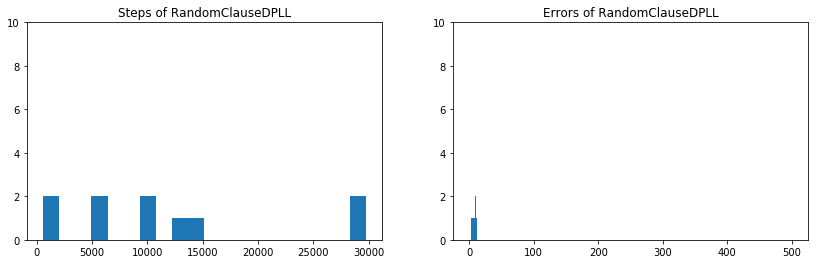

100%|██████████| 10/10 [00:44<00:00,  4.21s/it]


#Sats: 10; avg step: 3107.80; stdev step: 2620.06; avg error: 2.70; stdev error: 2.15


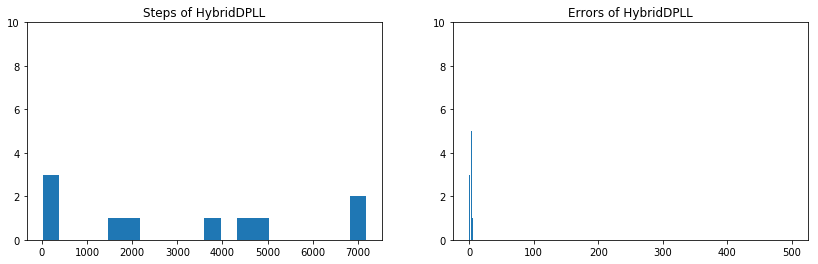

 60%|██████    | 6/10 [23:34<14:37, 219.49s/it]

In [ ]:
print_all(10, 500, 25)

In [ ]:
print_all(10, 500, 30)

In [ ]:
print_all(10, 500, 40)

In [ ]:
print_all(10, 500, 50)